In [ ]:
# Import required libraries
import pandas as pd
import os
import csv
import json 

In [ ]:
# The following code inserts the data from the CSV into a dataframe
df = pd.read_csv('advertisers_using_your_activity_or_information2.csv')

#View the dataframe
df.head(5)

,advertiser_name,has_data_file_custom_audience,has_remarketing_custom_audience,has_in_person_store_visit
0,Konga.com,True,True,False
1,MultiChoice Group,True,True,False
2,PayPal,True,True,False
3,MTN Nigeria,True,True,False
4,Binance,True,True,False


In [ ]:
unique_advertisers = df.advertiser_name.unique()
print(" # Unique advertisers",  len(unique_advertisers))

 # Unique advertisers 714


In [ ]:
!pip install -qq openai wikipedia transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 99.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.3 MB/s eta 0:00:00


In [ ]:
import wikipedia  

In [ ]:
# function to get wikipedia summary of each advertiser where possible 
def get_wiki_summary(query):
  try:
    return wikipedia.summary(query)
  except:
    return None
advertiser_summaries = df.advertiser_name.apply(lambda x: get_wiki_summary(x))

In [ ]:
df["summary"] = advertiser_summaries  

In [ ]:
import requests
import json
import re

endpoint = 'https://api.bing.microsoft.com/v7.0/search/'
api_key = 'get_your_own'


def get_results(query):
    headers = {'Ocp-Apim-Subscription-Key': api_key}
    params = {'q': query, 'textDecorations': True, 'textFormat': 'HTML', 'count': 10}
    response = requests.get(endpoint, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    if "webPages" in search_results:
      return search_results["webPages"]["value"][0]["snippet"]
    else:
      return None

def update_summary(summary, advertiser):
  
  if summary == None:
    return get_results(advertiser)
  else:
    return summary


In [ ]:
df["summaryx"] = df.apply(lambda x: update_summary(x.summary, x.advertiser_name), axis=1)

In [ ]:
df.head(5)

,advertiser_name,has_data_file_custom_audience,has_remarketing_custom_audience,has_in_person_store_visit,summary,summaryx
0,Konga.com,True,True,False,None,"Shop Online for Electronics, Phones, Computers..."
1,MultiChoice Group,True,True,False,None,DStv is a sub-Saharan African video entertainm...
2,PayPal,True,True,False,None,<b>Paypal</b> Home. Shopping online shouldn&#3...
3,MTN Nigeria,True,True,False,None,Stay connected. Explore our affordable data an...
4,Binance,True,True,False,None,<b>Binance</b> stores 10% of all trading fees ...


In [ ]:
categories = [
{ "Entertainment" : "Entertainment category, for example DSTV, Multichoice, spotify"},
{"Cryptocurrency" : "Cryptocurrency, for example Binance, Crypto, Bitcoin, Etherium"},
{"Education" : "Education category, for example university, learning, education, edx, coursera, udemy, quizlet, udacity, IELTS"},
{"Sports" : "Sports category, for example Sports, Adidas, Fifa"},
{"Technology and Gaming" : "Technology and Gaming category, for example Microsoft, Computer, Teamviewer, ASUS, Webex, Tech, Shadow Fight, Games, Nekki"},
{"Career and Business" : "Career and Business category, for example Tek Experts, Bloomberg, Bluefocus, Insider Business, Quillbot, Business, Group, Enterprises, Limited, Bank, TestGorilla, job, Oil and Gas"},
{"Housing" : "Housing category, for example Housing, Homes, Estate"},
{"Health and Fitness" : "Health and Fitness category, for example yoga, FitCoach, fitness, fit"},
{"Social Media" : "Social Media category, for example Viber, Instagram, Snapchat, YouTube"}, 
]
df["ind"] = list(df.index)
category_titles = [list(x.keys())[0] for x in categories]
category_titles 

['Entertainment',
 'Cryptocurrency',
 'Education',
 'Sports',
 'Technology and Gaming',
 'Career and Business',
 'Housing',
 'Health and Fitness',
 'Social Media']

In [ ]:
from transformers import pipeline
nlp = pipeline("zero-shot-classification", model="joeddav/bart-large-mnli-yahoo-answers", device=0)

In [ ]:
hypothesis_template = "This text is about {}."
x = 0
def get_label(sequence_to_classify, i, advertiser):
  if sequence_to_classify == None:
    return None
  result = nlp(sequence_to_classify, category_titles, multi_label=True, hypothesis_template=hypothesis_template, device=0)
  print(i, advertiser, ":",  result["labels"][0])
  return result["labels"][0]

In [ ]:
df["category"] = df.apply(lambda x: get_label(x.summaryx, x.ind, x.advertiser_name ), axis=1)

0 Konga.com : Technology and Gaming
1 MultiChoice Group : Entertainment
2 PayPal : Cryptocurrency
3 MTN Nigeria : Social Media
4 Binance : Cryptocurrency
5 Interaction Design Foundation - IXDF : Technology and Gaming
6 Chegg : Technology and Gaming
7 Showmax : Entertainment
8 Bolt : Health and Fitness
9 A.L. Amazing Apps : Career and Business
10 Uber : Career and Business
11 LinkedIn : Career and Business
12 Coursera : Career and Business
13 Adobe : Technology and Gaming
14 Essenza Nigeria : Health and Fitness
15 Артем Kriklivets : Social Media
16 JetPex : Social Media
17 Trung Messi 12 - 5902 : Technology and Gaming
18 WTWH Media : Career and Business
19 Gold Rush Media : Entertainment
20 Jason McCabe Calacanis : Career and Business
21 AE Marketing : Career and Business
22 Monsif market : Career and Business
23 ZIZA Digital : Career and Business
24 Wild Fusion : Career and Business
25 Newlook.smm : Social Media
26 Gameroad Limited : Career and Business
27 Brilliant.org : Technology an

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


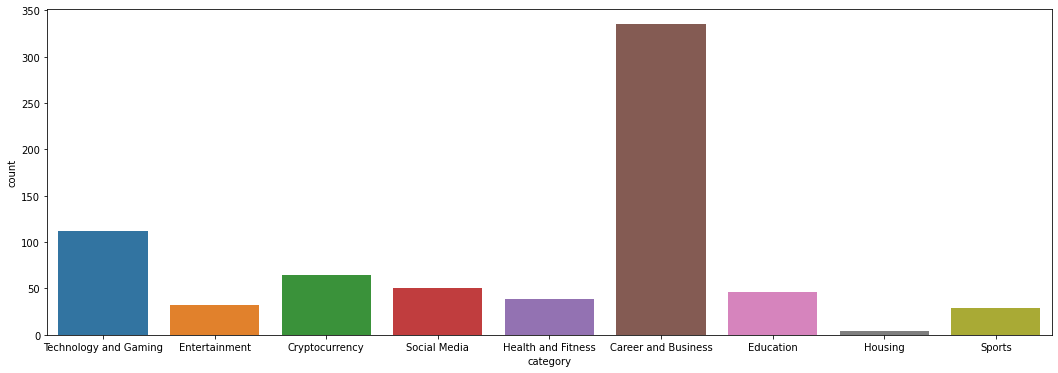

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))

sns.countplot(df.category)

In [ ]:
df.head(5)

,advertiser_name,has_data_file_custom_audience,has_remarketing_custom_audience,has_in_person_store_visit,summary,summaryx,ind,category
0,Konga.com,True,True,False,None,"Shop Online for Electronics, Phones, Computers...",0,Technology and Gaming
1,MultiChoice Group,True,True,False,None,DStv is a sub-Saharan African video entertainm...,1,Entertainment
2,PayPal,True,True,False,None,<b>Paypal</b> Home. Shopping online shouldn&#3...,2,Cryptocurrency
3,MTN Nigeria,True,True,False,None,Stay connected. Explore our affordable data an...,3,Social Media
4,Binance,True,True,False,None,<b>Binance</b> stores 10% of all trading fees ...,4,Cryptocurrency


In [ ]:
df.to_csv("category.csv")

In [ ]:
df.category.value_counts()

Career and Business      335
Technology and Gaming    112
Cryptocurrency            64
Social Media              50
Education                 46
Health and Fitness        39
Entertainment             32
Sports                    29
Housing                    4
Name: category, dtype: int64